In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from your path
import pandas as pd

file_path = "/content/drive/MyDrive/drug_induced_autoimmunity_prediction/DIA_trainingset_RDKit_descriptors.csv"
df = pd.read_csv(file_path)

# Show basic info
print("🔢 Dataset Shape:", df.shape)
print("\n🧪 First few rows:")
print(df.head())

print("\n📋 Column Names:")
print(df.columns.tolist())

# Check for missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


Mounted at /content/drive
🔢 Dataset Shape: (477, 198)

🧪 First few rows:
   Label                                             SMILES  BalabanJ  \
0      0  COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...     1.821   
1      0                    C[C@H](N(O)C(=O)N)c1cc2ccccc2s1     2.363   
2      0                              C[N+](C)(C)CC(=O)[O-]     3.551   
3      1  CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...     2.076   
4      1           C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O     2.888   

    BertzCT    Chi0   Chi0n   Chi0v    Chi1  Chi1n  Chi1v  ...  fr_sulfide  \
0  1266.407  22.121  16.781  16.781  14.901  9.203  9.203  ...           0   
1   490.434  11.707   8.752   9.569   7.592  4.854  5.670  ...           0   
2    93.092   6.784   5.471   5.471   3.417  2.420  2.420  ...           0   
3  1053.003  21.836  16.995  16.995  14.274  9.926  9.926  ...           0   
4   549.823  14.629   9.746   9.746   8.752  5.040  5.040  ...           0   

   fr_sulfonamd  fr

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop target and non-numeric columns
X = df.drop(columns=['Label', 'SMILES'])

# -------- 1. No Preprocessing --------
X_raw = X.copy()

# -------- 2. StandardScaler --------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------- 3. StandardScaler + PCA --------
pca = PCA(n_components=0.95, random_state=42)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Show shapes
print("✅ Raw shape:", X_raw.shape)
print("✅ Scaled shape:", X_scaled.shape)
print("✅ PCA shape (95% variance):", X_pca.shape)


✅ Raw shape: (477, 196)
✅ Scaled shape: (477, 196)
✅ PCA shape (95% variance): (477, 70)


In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels)
    }

# To store all results
results = []

# ------- KMeans (k=2,3,4) -------
for k in [2, 3, 4]:
    for name, data in zip(['Raw', 'Scaled', 'PCA'], [X_raw, X_scaled, X_pca]):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        scores = evaluate_clustering(data, labels)
        results.append({
            "Algo": f"KMeans (k={k})",
            "Preprocessing": name,
            **scores
        })

# ------- Agglomerative Clustering -------
for k in [2, 3, 4]:
    for name, data in zip(['Raw', 'Scaled', 'PCA'], [X_raw, X_scaled, X_pca]):
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        scores = evaluate_clustering(data, labels)
        results.append({
            "Algo": f"Agglomerative (k={k})",
            "Preprocessing": name,
            **scores
        })

# ------- DBSCAN -------
for name, data in zip(['Raw', 'Scaled', 'PCA'], [X_raw, X_scaled, X_pca]):
    dbscan = DBSCAN(eps=2.0, min_samples=5)
    labels = dbscan.fit_predict(data)
    if len(set(labels)) > 1 and -1 not in set(labels):  # avoid degenerate/noise-only clustering
        scores = evaluate_clustering(data, labels)
        results.append({
            "Algo": "DBSCAN",
            "Preprocessing": name,
            **scores
        })
    else:
        results.append({
            "Algo": "DBSCAN",
            "Preprocessing": name,
            "Silhouette": np.nan,
            "Davies-Bouldin": np.nan,
            "Calinski-Harabasz": np.nan
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Clustering Evaluation Results:")
display(results_df.round(4))



📊 Clustering Evaluation Results:


,Algo,Preprocessing,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans (k=2),Raw,0.9937,0.0035,2249.7196
1,KMeans (k=2),Scaled,0.1252,2.5522,65.5818
2,KMeans (k=2),PCA,0.1319,2.4700,69.4255
3,KMeans (k=3),Raw,0.9926,0.2291,12462.9547
4,KMeans (k=3),Scaled,0.0711,2.8160,49.2407
5,KMeans (k=3),PCA,0.0764,2.6958,52.2785
6,KMeans (k=4),Raw,0.9916,0.1552,44426.7408
7,KMeans (k=4),Scaled,0.0754,2.6100,42.2781
8,KMeans (k=4),PCA,0.0860,2.4934,45.0350
9,Agglomerative (k=2),Raw,0.9937,0.0035,2249.7196


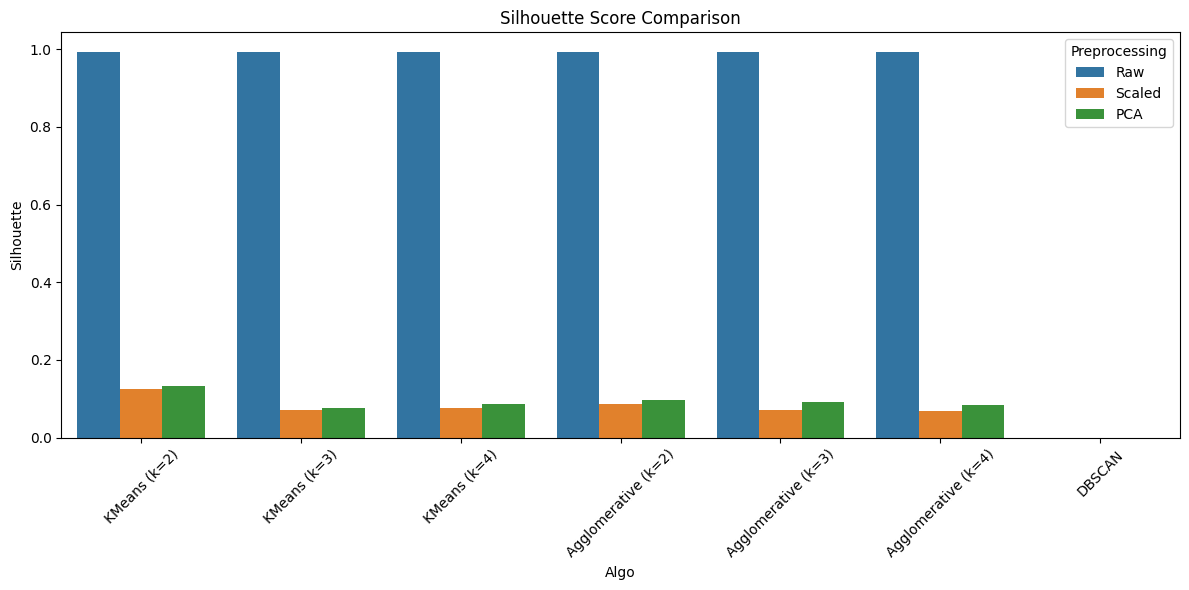

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Algo", y="Silhouette", hue="Preprocessing")
plt.xticks(rotation=45)
plt.title("Silhouette Score Comparison")
plt.tight_layout()
plt.show()
